In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import date
import datatable as dt 
%matplotlib inline

We will be examining the performance in trial vs control stores to provide a recommendation for each location based on our insight.

Select control stores – explore the data and define metrics for control store selection – "What would make them a control store?" Visualize the drivers to see suitability.

Assessment of the trial – get insights of each of the stores. Compare each trial store with ontrol store to get its overall performance. We want to know if the trial stores were successful or not.

Collate findings – summarise findings for each store and provide recommendations to share with client outlining the impact on sales during trial period.


In [68]:
df = dt.fread('QVI_data.csv').to_pandas()

In [75]:
df['DATE'] = pd.to_datetime(df['DATE'])

In [76]:
df.shape

(264834, 12)

In [77]:
# change name to lower
df.columns = df.columns.str.lower()

In [78]:
# Create yearmont columns
df.insert(1, 'year_month',df.date.dt.to_period('M'))

In [79]:
#find store_nbr that open by 12 month 
ck = df.groupby('store_nbr')['year_month'].nunique()
cklist = ck[ck == 12].index.to_list()
df = df[df.store_nbr.isin(cklist)]

In [80]:
df.head()

,lylty_card_nbr,year_month,date,store_nbr,txn_id,prod_nbr,prod_name,prod_qty,tot_sales,pack_size,brand,lifestage,premium_customer
0,1000,2018-10,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [81]:
# total sale by month ,Store 77, 86, 88
check = df[df['store_nbr'].isin([77, 86, 88])].groupby(['store_nbr', 'year_month'])['tot_sales'].sum()

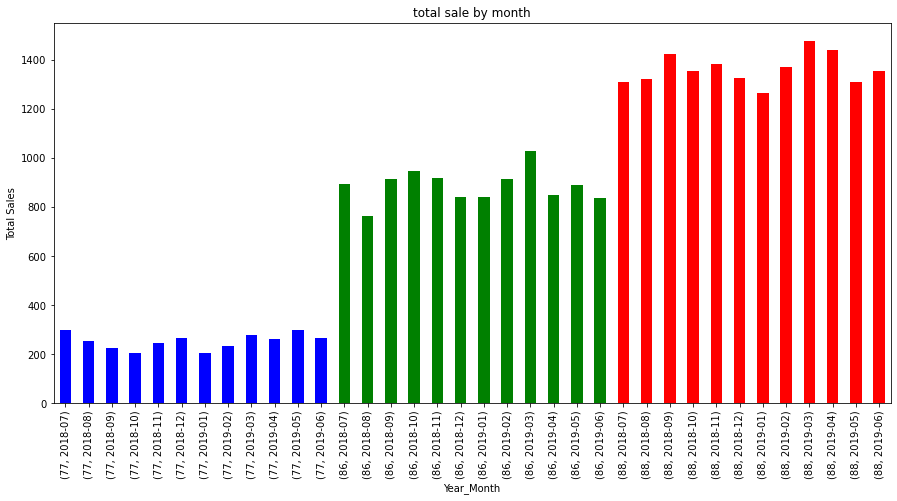

In [82]:
colors = []
for store, month in check.index:
    if store == 77:
        colors.append('b')
    elif store == 86:
        colors.append('g')
    else:
        colors.append('r')
check.plot(kind = 'bar',color = colors ,figsize = (15, 7))
plt.title('total sale by month')
plt.xlabel('Year_Month')
plt.ylabel('Total Sales')
plt.show()

### define metrics:

- Total sales
- Number of customers,
- Average transactions per customer


In [83]:
m_total_sales = df.groupby(['store_nbr', 'year_month'])['tot_sales'].sum()
m_cust = df.groupby(['store_nbr', 'year_month'])['lylty_card_nbr'].nunique()
m_transpercust = df.groupby(['store_nbr', 'year_month'])["txn_id"].nunique()/m_cust

In [84]:
store_with_metric = pd.concat([m_total_sales,m_cust,m_transpercust],axis=1)

In [85]:
store_with_metric.columns = ['m_total_sales', 'm_cust', 'm_transpercust']

In [86]:
store_with_metric.reset_index(inplace = True)

In [14]:
store_with_metric.head(12)

,store_nbr,year_month,m_total_sales,m_cust,m_transpercust
0,1,2018-07,206.9,49,1.061224
1,1,2018-08,176.1,42,1.023810
2,1,2018-09,278.8,59,1.050847
3,1,2018-10,188.1,44,1.022727
4,1,2018-11,192.6,46,1.021739
5,1,2018-12,189.6,42,1.119048
6,1,2019-01,154.8,35,1.028571
7,1,2019-02,225.4,52,1.057692
8,1,2019-03,192.9,45,1.088889
9,1,2019-04,192.9,42,1.023810


"pre_df" is the dataset which contains samples only before the trial period.

"trial_df" is the datset which contains samples of trial period.

In [15]:
pre_df = store_with_metric[store_with_metric['year_month'] <= "2019-01"]
trial_df = store_with_metric[(store_with_metric['year_month'] >= "2019-02") & (store_with_metric['year_month'] <= "2019-04")]

In [16]:
#pre df 7 month
pre_df.set_index(['store_nbr','year_month'],inplace =True)

In [19]:
# trial df 3 month
trial_df.set_index(['store_nbr','year_month'],inplace =True)

m_total_sales  m_cust  m_transpercust
store_nbr year_month                                       
1         2019-02             225.4      52        1.057692
          2019-03             192.9      45        1.088889
          2019-04             192.9      42        1.023810

In [18]:
pre_df.head(8)

m_total_sales  m_cust  m_transpercust
store_nbr year_month                                       
1         2018-07             206.9      49        1.061224
          2018-08             176.1      42        1.023810
          2018-09             278.8      59        1.050847
          2018-10             188.1      44        1.022727
          2018-11             192.6      46        1.021739
          2018-12             189.6      42        1.119048
          2019-01             154.8      35        1.028571
2         2018-07             150.8      39        1.051282

In [20]:
trial_df.reset_index(inplace = True)
pre_df.reset_index(inplace = True)

---------

In [22]:
def calculateCorrelation(df, metricCol, storeComparison):
       
    control_all = df.loc[~df["store_nbr"].isin([77,86,88])]
    trial = df.loc[df["store_nbr"] == storeComparison][metricCol].reset_index()
    calcCorrTable = pd.DataFrame(columns = ["Control_Store", "Trial_Store", "Corr"])
    
    for i in control_all["store_nbr"].unique():
        control = control_all[control_all["store_nbr"]==i][metricCol].reset_index()              
        correlation = control.corrwith(trial,axis=0)[1]
        calcCorrTable_i = pd.DataFrame({"Control_Store":i,"Trial_Store":storeComparison,"Corr":[correlation]}) 
        calcCorrTable = pd.concat([calcCorrTable, calcCorrTable_i])
     
    return calcCorrTable

In [23]:
def calculateMagnitudeDistance(df, metricCol, storeComparison):
    
    control_all = df.loc[~df["store_nbr"].isin([77,86,88])]
    trial = df.loc[df["store_nbr"] == storeComparison].reset_index()[metricCol]
    calcDistTable = pd.DataFrame(columns=["Control_Store", "Trial_Store", "Magnitude"])
    
    for i in control_all["store_nbr"].unique():
        control = control_all[control_all["store_nbr"]==i].reset_index()[metricCol]
        diff = abs(trial - control)
        # Standardise the magnitude distance so that the measure ranges from 0 to 1
        s_diff = np.mean(1-((diff-min(diff))/(max(diff)-min(diff))))
        calcDistTable_i = pd.DataFrame({"Control_Store":i,"Trial_Store":[storeComparison],"Magnitude": s_diff})
        calcDistTable = pd.concat([calcDistTable, calcDistTable_i])
    return calcDistTable

### Cal corr and magnitude in Pre-Period

In [24]:
# total sales - corr
corr_nSales_77 = calculateCorrelation(pre_df.reset_index(),"m_total_sales",77)

# total sales - magnitude distance
magnitude_nSales_77 = calculateMagnitudeDistance(pre_df.reset_index(),"m_total_sales",77) 

# number of customers - corr
corr_nCustomers_77 = calculateCorrelation(pre_df.reset_index(),"m_cust",77)

# number of customers - magnitude distance
magnitude_nCustomers_77 = calculateMagnitudeDistance(pre_df.reset_index(),"m_cust",77)

#### Cal Score totSales

In [25]:
nsales_77_cal  = pd.concat([corr_nSales_77,magnitude_nSales_77['Magnitude']],axis=1)

In [26]:
nsales_77_cal["score_nSales"] = 0.5 * nsales_77_cal["Corr"] + (1-0.5) * nsales_77_cal["Magnitude"]
nsales_77_cal.head()

,Control_Store,Trial_Store,Corr,Magnitude,score_nSales
0,1,77,0.075218,0.408163,0.241691
0,2,77,-0.263079,0.590119,0.163520
0,3,77,0.806644,0.522914,0.664779
0,4,77,-0.263300,0.644934,0.190817
0,5,77,-0.110652,0.516320,0.202834


In [27]:
ncust_77_cal  = pd.concat([corr_nCustomers_77,magnitude_nCustomers_77['Magnitude']],axis=1)

In [28]:
ncust_77_cal["score_nCust"] = 0.5 * ncust_77_cal["Corr"] + (1-0.5) * ncust_77_cal["Magnitude"]
ncust_77_cal.head()

,Control_Store,Trial_Store,Corr,Magnitude,score_nCust
0,1,77,0.322168,0.663866,0.493017
0,2,77,-0.572051,0.471429,-0.050311
0,3,77,0.834207,0.489796,0.662002
0,4,77,-0.295639,0.498258,0.101310
0,5,77,0.370659,0.512605,0.441632


#### Calculate final score with avg

In [59]:
#combine salesscore and cust score
finalControlScore_77 = pd.concat([nsales_77_cal[["Control_Store", "Trial_Store", "score_nSales"]],ncust_77_cal["score_nCust"]],axis=1)

# Calculate a final score 
corr_weight_c = 0.5
finalControlScore_77["finalControlScore"] = corr_weight_c * finalControlScore_77["score_nSales"] + (1-corr_weight_c) * finalControlScore_77["score_nCust"]

In [60]:
finalControlScore_77.sort_values(by="finalControlScore",ascending=False).head()

,Control_Store,Trial_Store,score_nSales,score_nCust,finalControlScore
0,233,77,0.697290,0.816607,0.756949
0,71,77,0.789497,0.663123,0.726310
0,84,77,0.656972,0.715000,0.685986
0,119,77,0.636046,0.729729,0.682887
0,115,77,0.708347,0.645155,0.676751


#### Store 233 high finalControlScore ,then we select them to control store for compare



## Plot compare store 77 and 119 

#### monthly_sale compare

In [35]:
pre_df.set_index(['store_nbr','year_month'],inplace = True)

In [37]:
pre_df.columns

Index(['m_total_sales', 'm_cust', 'm_transpercust'], dtype='object')

Text(0.5, 1.0, 'Distribution of monthly_sales store 77, 233')

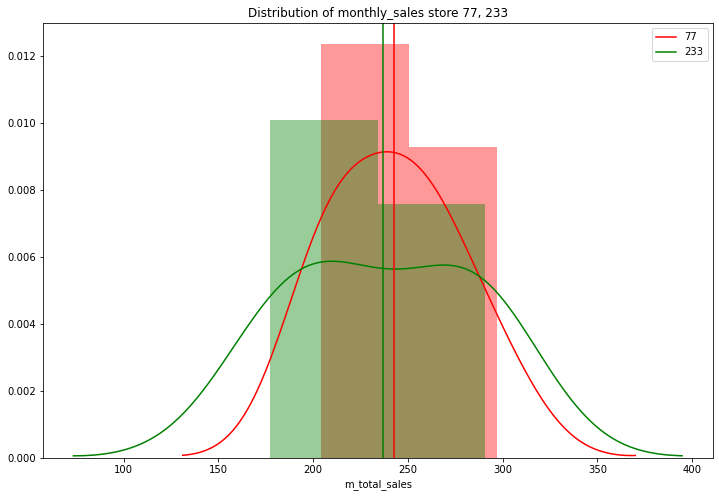

In [61]:
plt.figure(figsize = (12,8))
sns.distplot(pre_df.loc[77]['m_total_sales'], color = 'r')
sns.distplot(pre_df.loc[233]['m_total_sales'], color = 'g')

#add mean in vline
plt.axvline(pre_df.loc[77]['m_total_sales'].mean(),color='r')
plt.axvline(pre_df.loc[233]['m_total_sales'].mean(),color='g')
plt.legend(labels = ['77', '233'])
plt.title('Distribution of monthly_sales store 77, 233')

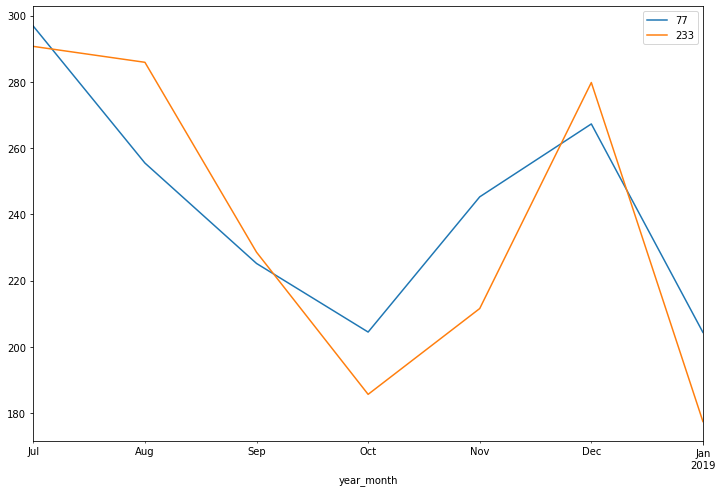

In [62]:
plt.figure(figsize = (12,8))
pre_df.loc[77]['m_total_sales'].plot()
pre_df.loc[233]['m_total_sales'].plot()
plt.legend(labels = ['77', '233'])

#### monthly_custs compare

Text(0.5, 1.0, 'Distribution of monthly_customers store 77, 233')

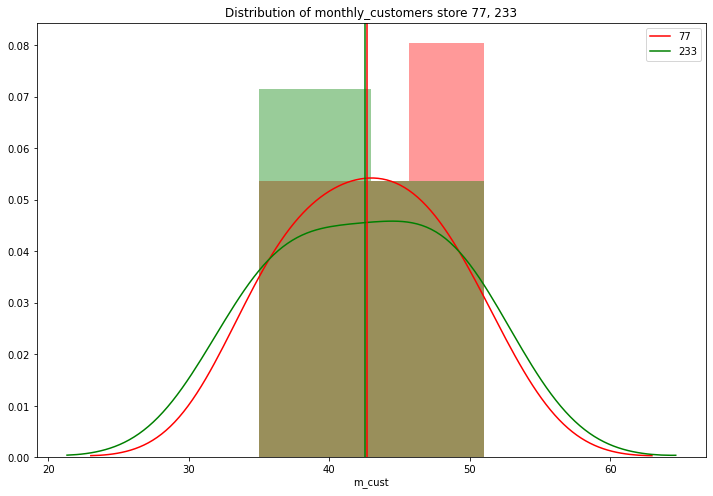

In [63]:
plt.figure(figsize = (12,8))
sns.distplot(pre_df.loc[77]['m_cust'], color = 'r')
sns.distplot(pre_df.loc[233]['m_cust'], color = 'g')

#add mean in vline
plt.axvline(pre_df.loc[77]['m_cust'].mean(),color='r')
plt.axvline(pre_df.loc[233]['m_cust'].mean(),color='g')
plt.legend(labels = ['77', '233'])
plt.title('Distribution of monthly_customers store 77, 233')

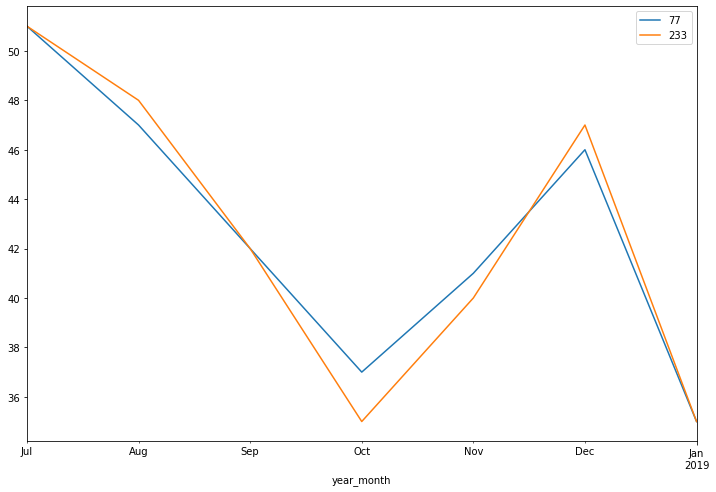

In [64]:
plt.figure(figsize = (12,8))
pre_df.loc[77]['m_cust'].plot()
pre_df.loc[233]['m_cust'].plot()
plt.legend(labels = ['77', '233'])

-------

In [43]:
import pingouin as pg

In [47]:
# t-test monthly_sale (pre)
pg.ttest(pre_df.loc[77]['m_total_sales'],pre_df.loc[233]['m_total_sales'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.250863,12,two-sided,0.806164,"[-43.04, 54.24]",0.134092,0.455,0.056159


In [46]:
# t-test monthly_custs (pre)
pg.ttest(pre_df.loc[77]['m_cust'],pre_df.loc[233]['m_cust'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.044382,12,two-sided,0.96533,"[-6.87, 7.16]",0.023723,0.446,0.050192


that both are similar (pvalues are high close to 1).

----------------

### test trial period


In [49]:
trial_df.set_index(['store_nbr','year_month'], inplace = True)

In [50]:
# t-test monthly_sale (trial)
pg.ttest(trial_df.loc[77]['m_total_sales'],trial_df.loc[233]['m_total_sales'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.104355,4,two-sided,0.103145,"[-18.66, 135.53]",1.718199,1.353,0.364469


In [51]:
# t-test monthly_custs (trial)
pg.ttest(trial_df.loc[77]['m_cust'],trial_df.loc[233]['m_cust'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.938487,4,two-sided,0.124594,"[-3.89, 21.89]",1.582768,1.227,0.319544


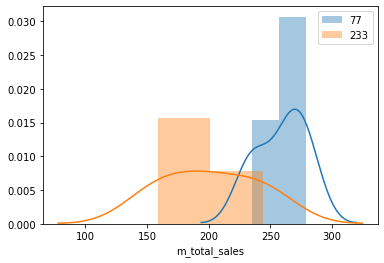

In [52]:
sns.distplot(trial_df.loc[77]['m_total_sales'])
sns.distplot(trial_df.loc[233]['m_total_sales'])
plt.legend(labels=['77','233'])

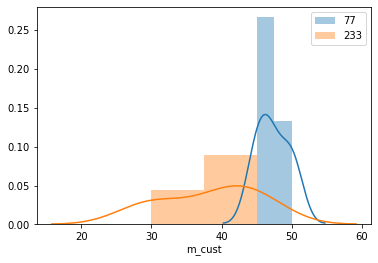

In [53]:
sns.distplot(trial_df.loc[77]['m_cust'])
sns.distplot(trial_df.loc[233]['m_cust'])
plt.legend(labels=['77','233'])

-----------


In [55]:
store_with_metric.set_index(['store_nbr','year_month'], inplace = True)

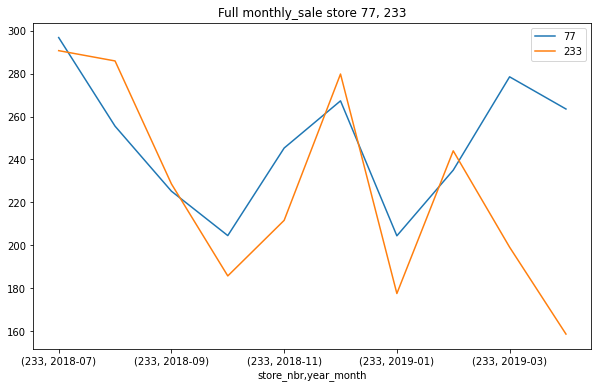

In [56]:
plt.figure(figsize = (10,6))
store_with_metric.loc[(77,'2018-07'):(77,'2019-04')]['m_total_sales'].plot()
store_with_metric.loc[(233,'2018-07'):(233,'2019-04')]['m_total_sales'].plot()
plt.title('Full monthly_sale store 77, 233')
plt.legend(labels = ['77', '233'])

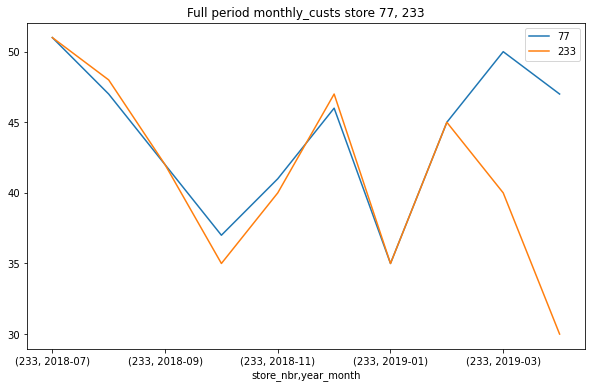

In [57]:
plt.figure(figsize = (10,6))
store_with_metric.loc[(77,'2018-07'):(77,'2019-04')]['m_cust'].plot()
store_with_metric.loc[(233,'2018-07'):(233,'2019-04')]['m_cust'].plot()
plt.title('Full period monthly_custs store 77, 233')
plt.legend(labels = ['77', '233'])

conclution : significant increase in sales of chips in trial stores in the trial period.

---------------